# Preprocessing

In [1]:
# math and data packages
import pandas as pd
import numpy as np
import math

# charting and graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# os and file types
import os
import sys
import datetime as dt
import json
import csv
from collections import defaultdict

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex



## Import data

Fix any known formatting problems here

In [2]:
# make slugs for species and places

# function to make the species slugs
def to_slug(x):
    try: 
        int_data = x.split()
        data = int_data[:2]
        data = "-".join(data)
        data = data.lower()
    except:
        data = "none"
    return data


def asplit(x):
    akey=x
    int_data = x.strip().split("-")
    return int_data, akey

def check_length(x):
    data = len(x[0])
    return data, x[0], x[1]

def new_data(data, suffixes, threecharacters, twocharacters):
    """Removes the specified suffix from a string"""
    
    if data[0] == 1:        
        if data[1][0].endswith(suffixes):
            new_x = data[1][:-4]
        elif data[1][0].endswith(threecharacters):
            new_x = data[1][:-3]
        else:
            new_x = data[1][0]
    else:
        
        if data[1][1] in suffixes:
            new_x = data[1][0]
        elif data[1][1].endswith(threecharacters):
            new_x = data[1][0]
        elif data[1][1].endswith(twocharacters):
            new_x = data[1][0]
        else:
            new_x = "-".join(data[1])            
    
    return {data[2]:new_x}

def change_a_column_value(df,coltocopy, coltorecieve, this_function=to_slug):
    copyname = f"{coltocopy}_copy"
    df[copyname] = df[coltocopy]
    df[coltorecieve] = df[copyname].map(lambda x: this_function(x))
    return df

def columns_to_lower(df, oldnames):
    new_names = {x:x.lower() for x in oldnames}
    return df.rename(columns=new_names, inplace=True)

invasives = pd.read_csv("resources/inprocess/invasives.csv")
priority = pd.read_csv("resources/inprocess/priority.csv")
redlist = pd.read_csv("resources/inprocess/redlist.csv")
surveys = pd.read_csv("resources/inprocess/combined_survey_data.csv")

from numpy.random import default_rng
rng = default_rng()
locations = ["a", "b", "c"]
nsurveys = surveys.loc_date.nunique()
loc_groups = rng.choice(locations, nsurveys, p=[.2,.2,.6])

loc_date_group = {x:loc_groups[i] for i,x in enumerate(surveys.loc_date.unique())}

surveys["location"] = surveys.loc_date.map(lambda x: loc_date_group[x])



invasives = change_a_column_value(invasives, "Latin", "species", to_slug)[["species", "list_2014", "Ordonnonce sur la dissémination des organismes (ODE)"]]
invcolumns = ["species", "list_2014", "Ordonnonce sur la dissémination des organismes (ODE)", "acopy"]
invasives = invasives.rename(columns={invcolumns[2]:"ode"})
invasives["ode"] = invasives.ode.where(invasives.ode == "ODE", "X")
invasives.drop_duplicates(subset="species", inplace=True)
invdata = invasives[["species", "list_2014","ode"]].set_index("species", drop=True)

priority = change_a_column_value(priority, "species", "species", to_slug)[["species", "Jura", "Plateau", "responsabilite", "priorite"]]
pricolumns = ["species", "Jura", "Plateau", "responsabilite", "priorite", "acopy"]
new_names = {x:x.lower() for x in pricolumns}
priority.rename(columns=new_names, inplace=True)
priority.rename(columns={"jura":"JU", "plateau":"MP"},inplace=True)
priority.drop_duplicates(subset="species", inplace=True)
priority.set_index("species", inplace=True, drop=True)


redlist = change_a_column_value(redlist, "species", "species", to_slug)[["species", "CH", "JU", "MP"]]
redlist.drop_duplicates(subset="species", inplace=True)
redlist.set_index("species", inplace=True, drop=True)

In [3]:
redlist.head()

,CH,JU,MP
species,,,
abies-alba,LC,LC,LC
acer-campestre,LC,LC,LC
acer-opalus,LC,LC,NT
acer-platanoides,LC,LC,LC
acer-pseudoplatanus,LC,LC,LC


In [8]:
priority = priority[["responsabilite", "priorite"]].copy()
priority

,responsabilite,priorite
species,,
achillea-atrata,3,4
achillea-clavenae,2,3
achillea-collina,1,4
achillea-erba-rotta,3,4
achillea-macrophylla,3,4
...,...,...
woodsia-ilvensis,3,2
woodsia-pulchella,2,2
xanthium-strumarium,1,3


In [5]:
invdata.head()

,list_2014,ode
species,,
abutilon-theophrasti,BL,X
ailanthus-altissima,BL,X
ambrosia-artemisiifolia,BL,ODE
amorpha-fruticosa,BL,X
artemisia-verlotiorum,BL,X


In [35]:
all_species = set([*invdata.index, *priority.index, *redlist.index])
fd = pd.DataFrame(index=all_species)

rchmap = redlist.CH
rjumap = redlist.JU
rmpmap = redlist.MP
for a in all_species:
    # redlist:
    if a in redlist.index:
        fd.loc[a, "rch" ] = rchmap.loc[a]
        fd.loc[a, "rmp" ] = rjumap.loc[a]
        fd.loc[a, "rju" ] = rjumap.loc[a]

res = priority.responsabilite
pri = priority.priorite
        
for a in all_species:
    # national priority list:
    if a in priority.index:
        fd.loc[a, "res"] = res.loc[a]
        fd.loc[a,"pri"] = pri.loc[a]

inv = invdata.list_2014
ode = invdata.ode

for a in all_species:
    # national priority list:
    if a in invdata.index:
        fd.loc[a, "inv"] = inv.loc[a]
        fd.loc[a,"ode"] = ode.loc[a]        
        

fd.fillna('X',inplace = True)



In [45]:
z = surveys.species.unique()

In [46]:
surveys.loc[surveys.species==z[0],"rch"]

0       LC
2157    LC
2170    LC
2175    LC
2229    LC
        ..
7640    LC
7778    LC
7810    LC
7862    LC
7889    LC
Name: rch, Length: 128, dtype: object

In [47]:
fd.loc[]

'LC'

In [56]:
for val in surveys.species.unique():
    # national priority list:
    if val in fd.index:
        data = fd.loc[val]
        newcols = data.index
        for col in newcols:
            surveys.loc[surveys.species==val, col] = data.loc[col]
            
    else:
        pass
    

In [55]:
fd.loc[z[0]].index

Index(['rch', 'rmp', 'rju', 'res', 'pri', 'inv', 'ode'], dtype='object')

In [59]:
surveys.to_csv("resources/inprocess/master.csv")

In [6]:
lists = [invdata, priority, redlist]

# get the set of unique species names in all the lists
the_lists = [invdata.index, priority.index, redlist.index]
uniques = np.concatenate(the_lists)
uniques = list(set(uniques))

list_labels = ["invasives", "priority", "redlist"]

list_index = {0:list_labels[0], 1:list_labels[1], 2:list_labels[2]}

# the binomial
s_sp = surveys.species.sort_values().unique()
sp_k = list(zip(np.arange(len(s_sp)), s_sp))

In [8]:
def the_list_value(x,alist, the_xcoord):
    the_val = alist[alist[the_xcoord].isin([x])].to_numpy()
    if len(the_val) > 1:
        data = the_val
    else:
        data = the_val
    return data
    


def define_list_membership(alist, others, contains=True, list_index=list_index):
    all_results = {}
    for i,name in enumerate(alist):
        name_results = {}
        for j,aseries in enumerate(others):
            if contains:
                name_results.update({j:aseries.str.contains(name, regex=False, case=False).sum()})
            else:
                name_results.update({j:(aseries == name).sum()})
                # aval = the_list_value(x, aseries, name
        all_results.update({name:name_results})
    data = pd.DataFrame.from_dict(all_results, orient="index")
    data.rename(columns=list_index, inplace=True)        
       
    return data
def the_species_status(myobject, species_to_list):
    try:
        a = species_to_list.loc[myobject]
    except:
        print("Not in list?")
        a = myobject
    return a

def retrieve_the_required_lists(a_value, alist):
    
    if a_value:
        data=alist
        hasdata=True
    else:
        data = pd.DataFrame()
        hasdata=False            
    
    return hasdata, data

def retrieve_records(hasdata, data, this_species):
    
    if hasdata:        
        record=data.loc[this_species]
    else:
        record=pd.DataFrame([{"status":False}])
    
    return record    

def species_status(myobject, a_values, lists, list_index, add_cols=[], new_cols=[]):
    
    wiw = {}
    
    for i in np.arange(len(a_values)):
        if a_values[i]:
            hasdata, data = retrieve_the_required_lists(a_values[i], lists[i])
            
            data = retrieve_records(hasdata, data, myobject).rename(list_index[i])
            
            data["isin"] = True
            data["label"] = list_index[i]
            if list_index[i] in add_cols:
                for acol in new_cols:
                    data[acol] = "X"
            
            data.index.rename(myobject, inplace=True)
            data = data.to_frame()
        else:
            data = pd.DataFrame([False,list_index[i]], columns=[list_index[i]], index=pd.Index(["isin", "label"], name=myobject))
        
            
        wiw.update({list_index[i]:data})
    data = pd.concat([wiw["invasives"], wiw["priority"], wiw["redlist"]], axis=1).fillna("X")
    return data


def the_number_of_sightings(myobject, surveyobject, column="species", groups=["year"]):
    
    these_surveys = surveyobject.loc[surveyobject[column] == myobject].copy()
    sightings = these_surveys.groupby(groups).loc_date.nunique()
    
    return sightings

def the_number_of_locations(myobject, surveyobject, column="species",groups=["year"]):
    these_surveys = surveyobject.loc[surveyobject[column] == myobject].copy()
    locations = these_surveys.groupby(groups).place.nunique()    
    
    return locations

# this indexex a species with memberhip in list:
mem_data = define_list_membership(s_sp, the_lists, contains=False)


def the_species_status(myobject, species_to_list):
    try:
        a = species_to_list.loc[myobject]
    except:
        print("Not in list?")
        a = myobject
    return a

def retrieve_the_required_lists(a_value, alist):
    
    if a_value:
        data=alist
        hasdata=True
    else:
        data = pd.DataFrame()
        hasdata=False            
    
    return hasdata, data

def retrieve_records(hasdata, data, this_species):
    
    if hasdata:        
        record=data.loc[this_species]
    else:
        record=pd.DataFrame([{"status":False}])
    
    return record    

def species_status(myobject, a_values, lists, list_index, add_cols=[], new_cols=[]):
    
    wiw = {}
    
    for i in np.arange(len(a_values)):
        if a_values[i]:
            hasdata, data = retrieve_the_required_lists(a_values[i], lists[i])
            
            data = retrieve_records(hasdata, data, myobject).rename(list_index[i])
            
            data["isin"] = True
            data["label"] = list_index[i]
            if list_index[i] in add_cols:
                for acol in new_cols:
                    data[acol] = "X"
            
            data.index.rename(myobject, inplace=True)
            data = data.to_frame()
        else:
            data = pd.DataFrame([False,list_index[i]], columns=[list_index[i]], index=pd.Index(["isin", "label"], name=myobject))
        
            
        wiw.update({list_index[i]:data})
    data = pd.concat([wiw["invasives"], wiw["priority"], wiw["redlist"]], axis=1).fillna("X")
    return data


def the_number_of_sightings(myobject, surveyobject, column="species", groups=["year"]):
    
    these_surveys = surveyobject.loc[surveyobject[column] == myobject].copy()
    sightings = these_surveys.groupby(groups).loc_date.nunique()
    
    return sightings

def the_number_of_locations(myobject, surveyobject, column="species",groups=["year"]):
    these_surveys = surveyobject.loc[surveyobject[column] == myobject].copy()
    locations = these_surveys.groupby(groups).place.nunique()    
    
    return locations
def npe_method(tests):
    ret = defaultdict(int)
    for d in tests:
        for k, v in d.items():
            ret[k] += v
    return dict(ret)

def collect_the_different_status(data, func, alist="redlist", cols=[]):
    
    summaries = []
    
    for i,result in enumerate(data):
        
        aresult = func(data[result], cols=cols, alist=alist)
        summaries.append(aresult)
    
    asumm = [x[alist][cols] for x in summaries]   
    
    return asumm



# create a species object for each sighting
def make_a_collection_of_objects(sp_samp, species_to_list):
    
    data =  [species_status(x, the_species_status(x, species_to_list), lists, list_index,  add_cols=add_cols, new_cols=new_cols) for x in sp_samp]    
    
    return data

def summarize_species_objects(objs, list_labels):
    data = pd.DataFrame(columns=["species","label",*myregions,'responsabilite', 'priorite',"ode", "list_2014"])
    wiw = []
    for eachobject in objs:
        for alist in list_labels:
            dx = {x:eachobject[alist].loc[x] for x in eachobject.index}
            dx.update({"species":eachobject.index.name})
            wiw.append(dx)
    sr = data.append(wiw).fillna("X")
    return sr

def the_status_from_a_collection_of_surveys(sp_obj_df, cols= [], alist="priority"):
    h1 =  sp_obj_df[(sp_obj_df.label == alist)&(sp_obj_df[contains] == True)][cols]
    adict = {alist:{}}
    for acol in cols:
        lm = {x:h1[acol].value_counts().loc[x] for x in h1[acol].value_counts().index.values}
        adict[alist].update({acol:lm})    
    return adict
def the_redlist_incidence_from_a_collection_of_surveys(sp_obj_df, cols= [], alist="redlist", norm=False):
    
    h = sp_obj_df[(sp_obj_df.label == alist)&(sp_obj_df[contains] == True)][cols]
    data = {alist:{ar:{x:h.value_counts(norm).loc[x] for x in h.value_counts().index}}}
    
    return data
def simple_stacked_bar(ax,data, cats, bottom=0, **kwargs):
    for i,day in enumerate(data):
    
        bot = bottom
        for j,acat in enumerate(categories):
            try:
                y=day[acat]
            except:
                y=0

            ax.bar(i, y, bottom=bot, label=acat, color=a(j), width=1, **kwargs)
            bot += y
    return ax
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
def npe_method(tests):
    ret = defaultdict(int)
    for d in tests:
        for k, v in d.items():
            ret[k] += v
    return dict(ret)

def collect_the_different_status(data, func, alist="redlist", cols=[]):
    
    summaries = []
    
    for i,result in enumerate(data):
        
        aresult = func(data[result], cols=cols, alist=alist)
        summaries.append(aresult)
    
    asumm = [x[alist][cols] for x in summaries]   
    
    return asumm



# create a species object for each sighting
def make_a_collection_of_objects(sp_samp, species_to_list):
    
    data =  [species_status(x, the_species_status(x, species_to_list), lists, list_index,  add_cols=add_cols, new_cols=new_cols) for x in sp_samp]    
    
    return data

def summarize_species_objects(objs, list_labels):
    data = pd.DataFrame(columns=["species","label",*myregions,'responsabilite', 'priorite',"ode", "list_2014"])
    wiw = []
    for eachobject in objs:
        for alist in list_labels:
            dx = {x:eachobject[alist].loc[x] for x in eachobject.index}
            dx.update({"species":eachobject.index.name})
            wiw.append(dx)
    sr = data.append(wiw).fillna("X")
    return sr

def the_status_from_a_collection_of_surveys(sp_obj_df, cols= [], alist="priority"):
    h1 =  sp_obj_df[(sp_obj_df.label == alist)&(sp_obj_df[contains] == True)][cols]
    adict = {alist:{}}
    for acol in cols:
        lm = {x:h1[acol].value_counts().loc[x] for x in h1[acol].value_counts().index.values}
        adict[alist].update({acol:lm})    
    return adict
def the_redlist_incidence_from_a_collection_of_surveys(sp_obj_df, cols= [], alist="redlist", norm=False):
    
    h = sp_obj_df[(sp_obj_df.label == alist)&(sp_obj_df[contains] == True)][cols]
    data = {alist:{ar:{x:h.value_counts(norm).loc[x] for x in h.value_counts().index}}}
    
    return data
def simple_stacked_bar(ax,data, cats, bottom=0, **kwargs):
    for i,day in enumerate(data):
    
        bot = bottom
        for j,acat in enumerate(categories):
            try:
                y=day[acat]
            except:
                y=0

            ax.bar(i, y, bottom=bot, label=acat, color=a(j), width=1, **kwargs)
            bot += y
    return ax
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

### Given the list of invasive, threatened and priority species answer the following questions in relation to the survey results from 2020 and 2021

__The big numbers__

1. Number of samples
2. Number of locations
3. Date range
4. Number of species on the lists identified

### 


In [9]:
# species object
# for any species in the surveys
myobject = "fritillaria-meleagris"
myregions = [ "CH", "MP", "JU"]
mygroups = ["a", "b", "c"]
add_cols = ["invasives", "redlist"]
new_cols = ["responsabilite", "priorite"]
# the intitial query for the object
# establishes which list has data for this species
a = the_species_status(myobject, mem_data)
# a is used to generate b, a  data frame that that has the status of myobject
# according to the different lists
b = species_status(myobject, a, lists, list_index, add_cols=add_cols, new_cols=new_cols)
# this is one species object
b

,invasives,priority,redlist
fritillaria-meleagris,,,
isin,False,True,True
label,invasives,priority,redlist
JU,X,A,B1ab(iv)
MP,X,0,EN
responsabilite,X,1,X
priorite,X,3,X
CH,X,X,EN


In [10]:
def npe_method(tests):
    ret = defaultdict(int)
    for d in tests:
        for k, v in d.items():
            ret[k] += v
    return dict(ret)

def collect_the_different_status(data, func, alist="redlist", cols=[]):
    
    summaries = []
    
    for i,result in enumerate(data):
        
        aresult = func(data[result], cols=cols, alist=alist)
        summaries.append(aresult)
    
    asumm = [x[alist][cols] for x in summaries]   
    
    return asumm



# create a species object for each sighting
def make_a_collection_of_objects(sp_samp, species_to_list):
    
    data =  [species_status(x, the_species_status(x, species_to_list), lists, list_index,  add_cols=add_cols, new_cols=new_cols) for x in sp_samp]    
    
    return data

def summarize_species_objects(objs, list_labels):
    data = pd.DataFrame(columns=["species","label",*myregions,'responsabilite', 'priorite',"ode", "list_2014"])
    wiw = []
    for eachobject in objs:
        for alist in list_labels:
            dx = {x:eachobject[alist].loc[x] for x in eachobject.index}
            dx.update({"species":eachobject.index.name})
            wiw.append(dx)
    sr = data.append(wiw).fillna("X")
    return sr

def the_status_from_a_collection_of_surveys(sp_obj_df, cols= [], alist="priority"):
    h1 =  sp_obj_df[(sp_obj_df.label == alist)&(sp_obj_df[contains] == True)][cols]
    adict = {alist:{}}
    for acol in cols:
        lm = {x:h1[acol].value_counts().loc[x] for x in h1[acol].value_counts().index.values}
        adict[alist].update({acol:lm})    
    return adict
def the_redlist_incidence_from_a_collection_of_surveys(sp_obj_df, cols= [], alist="redlist", norm=False):
    
    h = sp_obj_df[(sp_obj_df.label == alist)&(sp_obj_df[contains] == True)][cols]
    data = {alist:{ar:{x:h.value_counts(norm).loc[x] for x in h.value_counts().index}}}
    
    return data
def simple_stacked_bar(ax,data, cats, bottom=0, **kwargs):
    for i,day in enumerate(data):
    
        bot = bottom
        for j,acat in enumerate(categories):
            try:
                y=day[acat]
            except:
                y=0

            ax.bar(i, y, bottom=bot, label=acat, color=a(j), width=1, **kwargs)
            bot += y
    return ax
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
contains = "isin"
# the status of all the sightings from one sample:
# a random sample a survey object
one_sample = surveys[surveys.loc_date == surveys.loc_date.unique()[112]].copy()

# there are many species in a sample
one_sample.species.unique()

array(['medicago-sativa', 'daucus-carota', 'silene-vulgaris',
       'epilobium-hirsutum', 'urtica-dioica', 'solidago-canadensis',
       'galium-mollugo', 'trifolium-repens', 'clinopodium-vulgare',
       'leucanthemum-vulgare', 'trifolium-pratense', 'lotus-corniculatus',
       'onobrychis-viciifolia'], dtype=object)

In [11]:
# this indexex a species with memberhip in list:
many_samples = surveys[surveys.loc_date.isin(surveys.loc_date.unique()[4:30])].copy()

# for priority and redlist:
ar = myregions[1]

# for priority
respn = [ar, "responsabilite", "priorite"]

# for invasives
bl = ["list_2014", "ode"]

# the sightings
sp_samp = many_samples.species.unique()

species_to_list = define_list_membership(sp_samp, the_lists, contains=False)

# all the species objects from a survey
objs =  make_a_collection_of_objects(sp_samp, species_to_list)

sr = summarize_species_objects(objs, list_labels)

In [12]:
# redlist summary for a collection of survey results
# within a defined region

rls = the_redlist_incidence_from_a_collection_of_surveys(sr, cols= ar, alist="redlist")
rls

{'redlist': {'MP': {'LC': 60, 'NT': 6, 'DD': 2, 'VU': 1, 'NE': 1}}}

In [13]:
inv = the_status_from_a_collection_of_surveys(sr, cols= bl, alist="invasives")
inv

{'invasives': {'list_2014': {'BL': 6}, 'ode': {'X': 4, 'ODE': 2}}}

In [14]:
# invasives list summary

pri = the_status_from_a_collection_of_surveys(sr, cols= respn, alist="priority")
pri

{'priority': {'MP': {'0': 2, 'A': 1},
  'responsabilite': {1: 1, 2: 1, 3: 1},
  'priorite': {4: 2, 3: 1}}}

In [15]:
a = surveys.copy()
b = a.groupby(["loc_date", "place"], as_index=False).species.nunique()
excludes = b[b.species < 3].loc_date.unique()
d=a[(~a.loc_date.isin(excludes))]

a_subset = surveys[surveys.loc_date.isin(d.loc_date.unique())].copy()
a_subset["date"] = pd.to_datetime(a_subset["date"])
a_subset.sort_values(by="date", inplace=True)

# for each sample establish the list status of the identified species
samps = a_subset.loc_date.unique()

species_to_list = define_list_membership(a_subset.species.unique(), the_lists, contains=False)

# for each survey in the subset summarize the species status:
ssp= {}
for eachday in samps:
    
    aday = a_subset[a_subset.loc_date == eachday]
    objs =  make_a_collection_of_objects(aday.species.unique(), species_to_list)
    adaystatus = summarize_species_objects(objs, list_labels)
    ssp.update({eachday:adaystatus})

# samples from ssp
rls1 = the_redlist_incidence_from_a_collection_of_surveys(ssp[samps[13]], cols= ar, alist="redlist", norm=False)
rls2 = the_redlist_incidence_from_a_collection_of_surveys(ssp[samps[11]], cols= ar, alist="redlist", norm=False)
rls3 = the_redlist_incidence_from_a_collection_of_surveys(ssp[samps[12]], cols= ar, alist="redlist", norm=False)

# remove the identifiers and calculate the aggregated total
singles = [x["redlist"]["MP"] for x in [rls1, rls2, rls3]]
singles

[{'LC': 4}, {'LC': 3}, {'LC': 3}]

### Redlist status per sample

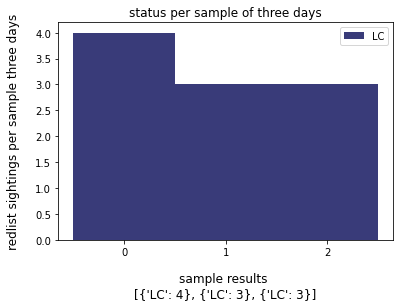

In [16]:
# chart that
totals = npe_method(singles)
categories = totals.keys()
a = get_cmap(len(categories), name='tab20b')
    
fig, ax = plt.subplots()

ax = simple_stacked_bar(ax,singles, categories, bottom=0)

ax.set_ylabel("redlist sightings per sample three days", fontsize=12, labelpad=15)
ax.set_xlabel(f"sample results \n{singles}", fontsize=12, labelpad=15)
ax.set_title("status per sample of three days")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [17]:
mindate = a_subset["date"].dt.date.min()
maxdate = a_subset["date"].dt.date.max()

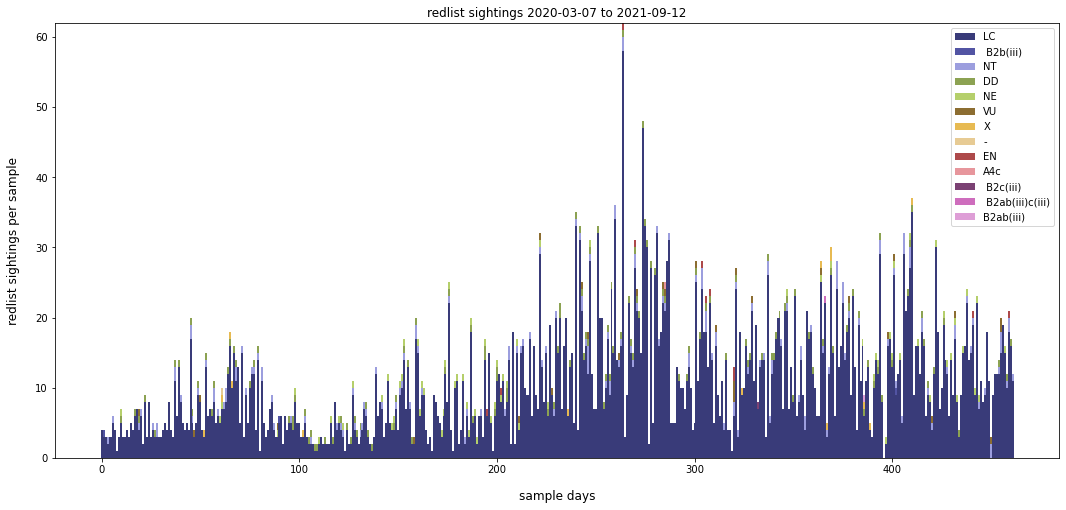

In [18]:
rlstall = [the_redlist_incidence_from_a_collection_of_surveys(ssp[asamps], cols= ar, alist="redlist", norm=False) for asamps in samps]
rs =  [x["redlist"]["MP"] for x in rlstall]

totals = npe_method(rs)
categories = totals.keys()
a = get_cmap(len(categories), name='tab20b')

fig, ax = plt.subplots(figsize=(18,8))

ax = simple_stacked_bar(ax,rs, categories, bottom=0)

ax.set_ylabel("redlist sightings per sample", fontsize=12, labelpad=15)
ax.set_xlabel("sample days", fontsize=12, labelpad=15)
ax.set_title(f"redlist sightings {mindate} to {maxdate}")
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [19]:
totals

{'LC': 4857,
 ' B2b(iii)': 3,
 'NT': 182,
 'DD': 142,
 'NE': 72,
 'VU': 30,
 'X': 14,
 '-': 1,
 'EN': 11,
 'A4c': 1,
 ' B2c(iii)': 1,
 ' B2ab(iii)c(iii)': 1,
 'B2ab(iii)': 1}

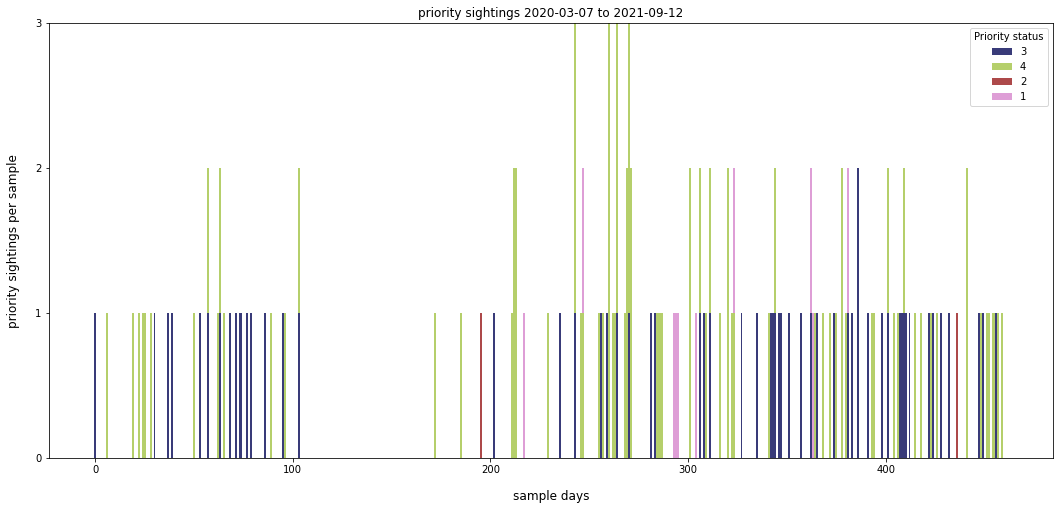

In [20]:
psamps = [the_status_from_a_collection_of_surveys(ssp[asamps], cols= respn, alist="priority") for asamps in samps]
ps =  [x["priority"]["priorite"] for x in psamps]

totals = npe_method(ps)
categories = totals.keys()
a = get_cmap(len(categories), name='tab20b')

fig, ax = plt.subplots(figsize=(18,8))

ax = simple_stacked_bar(ax,ps, categories, bottom=0)

ax.set_ylabel("priority sightings per sample", fontsize=12, labelpad=15)
ax.set_xlabel("sample days", fontsize=12, labelpad=15)
ax.set_title(f"priority sightings {mindate} to {maxdate}")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Priority status")
plt.show()

In [21]:
totals

{3: 59, 4: 84, 2: 2, 1: 10}

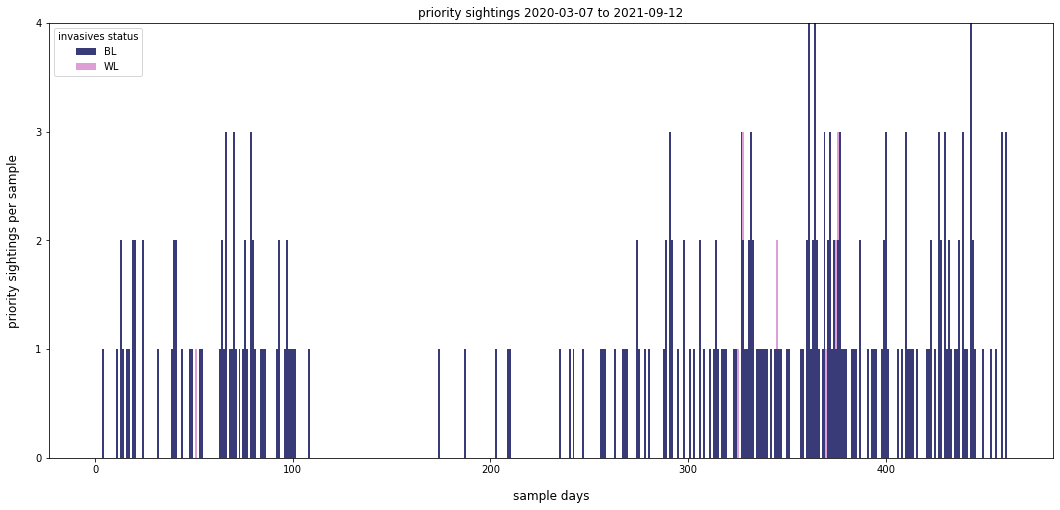

In [22]:
qsamps = [the_status_from_a_collection_of_surveys(ssp[asamps], cols= bl, alist="invasives") for asamps in samps]
qs =  [x["invasives"]["list_2014"] for x in qsamps]

totals = npe_method(qs)
categories = totals.keys()
a = get_cmap(len(categories), name='tab20b')

fig, ax = plt.subplots(figsize=(18,8))

ax = simple_stacked_bar(ax,qs, categories, bottom=0)

ax.set_ylabel("priority sightings per sample", fontsize=12, labelpad=15)
ax.set_xlabel("sample days", fontsize=12, labelpad=15)
ax.set_title(f"priority sightings {mindate} to {maxdate}")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="invasives status")
plt.show()

In [23]:
# this indexex a species with memberhip in list:
many_samples = surveys[surveys.loc_date.isin(surveys.loc_date.unique()[4:30])].copy()

# for priority and redlist:
ar = myregions[1]

# for priority
respn = [ar, "responsabilite", "priorite"]

# for invasives
bl = ["list_2014", "ode"]

# the sightings
sp_samp = many_samples.species.unique()

species_to_list = define_list_membership(sp_samp, the_lists, contains=False)

# all the species objects from a survey
objs =  make_a_collection_of_objects(sp_samp, species_to_list)

sr = summarize_species_objects(objs, list_labels)


In [24]:
sr

,species,label,CH,MP,JU,responsabilite,priorite,ode,list_2014,isin
0,epilobium-hirsutum,invasives,X,X,X,X,X,X,X,False
1,epilobium-hirsutum,priority,X,X,X,X,X,X,X,False
2,epilobium-hirsutum,redlist,LC,LC,LC,X,X,X,X,True
3,verbascum-thapsus,invasives,X,X,X,X,X,X,X,False
4,verbascum-thapsus,priority,X,X,X,X,X,X,X,False
...,...,...,...,...,...,...,...,...,...,...
271,geum-urbanum,priority,X,X,X,X,X,X,X,False
272,geum-urbanum,redlist,LC,LC,LC,X,X,X,X,True
273,buddleja-davidii,invasives,X,X,X,X,X,X,BL,True
274,buddleja-davidii,priority,X,X,X,X,X,X,X,False


In [25]:
# surveys of interest
somesurveys = surveys.loc_date.unique()

# identify the surveys of interest
mysurveys = somesurveys[53:74]

# slice the data to those surveys
a_subset = surveys[surveys.loc_date.isin(mysurveys)].copy()
a_subset["date"] = pd.to_datetime(a_subset["date"])
a_subset.sort_values(by="date", inplace=True)

mindate = a_subset["date"].min().date()
maxdate = a_subset["date"].max().date()

# # for each sample establish the list status of the identified species
species_to_list = define_list_membership(a_subset.species.unique(), the_lists, contains=False)

# for each survey in the subset summarize the species status:
ssp= {}
for eachday in samps:
    
    aday = a_subset[a_subset.loc_date == eachday]
    objs =  make_a_collection_of_objects(aday.species.unique(), species_to_list)
    adaystatus = summarize_species_objects(objs, list_labels)
    ssp.update({eachday:adaystatus})

# samples from ssp
rls1 = the_redlist_incidence_from_a_collection_of_surveys(ssp[mysurveys[13]], cols= ar, alist="redlist", norm=False)
rls2 = the_redlist_incidence_from_a_collection_of_surveys(ssp[mysurveys[11]], cols= ar, alist="redlist", norm=False)
rls3 = the_redlist_incidence_from_a_collection_of_surveys(ssp[mysurveys[12]], cols= ar, alist="redlist", norm=False)

# remove the identifiers and calculate the aggregated total
singles = [x["redlist"]["MP"] for x in [rls1]]
singles

[{'LC': 6, 'DD': 1}]

In [26]:
qsamps = [the_status_from_a_collection_of_surveys(ssp[asamps], cols= bl, alist="invasives") for asamps in mysurveys]
qs =  [x["invasives"]["list_2014"] for x in qsamps]

totals = npe_method(qs)
categories = totals.keys()
a = get_cmap(len(categories), name='tab20b')

fig, axs = plt.subplots(2,2, figsize=(12,12))

axi = simple_stacked_bar(axs[0,0],qs, categories, bottom=0)

axi.set_ylabel("invasive sightings per sample", fontsize=12, labelpad=15)
axi.set_title("invasives sightings")


psamps = [the_status_from_a_collection_of_surveys(ssp[asamps], cols= respn, alist="priority") for asamps in mysurveys]
ps =  [x["priority"]["priorite"] for x in psamps]

totals = npe_method(ps)
categories = totals.keys()
a = get_cmap(len(categories), name='tab20b')

axii = simple_stacked_bar(axs[0,1],ps, categories, bottom=0)

axii.set_ylabel("priority sightings", fontsize=12, labelpad=15)
axii.set_title(f"priority sightings")
axii.yaxis.set_major_locator(MaxNLocator(integer=True))
########################
rlstall = [the_redlist_incidence_from_a_collection_of_surveys(ssp[asamps], cols= ar, alist="redlist", norm=False) for asamps in mysurveys]
rs =  [x["redlist"]["MP"] for x in rlstall]

totals = npe_method(rs)
categories = totals.keys()
a = get_cmap(len(categories), name='tab20b')

axiii = simple_stacked_bar(axs[1,0],rs, categories, bottom=0)

axiii.set_ylabel("redlist sightings per sample", fontsize=12, labelpad=15)
axiii.set_title("redlist sightings")
#########################
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="invasives status")
plt.show()

KeyError: "('football 4', '03.07.2020')"

In [ ]:
# 
ssp[mysurveys[3]]

In [ ]:
a_subset.groupby("place", as_index=False).agg({"loc_date":"nunique", "species":"nunique"})

In [ ]:
a_subset.columns

In [ ]:
ssp[mysurveys[2]]

In [ ]:
count = {"priority":0, "invasive":0, "redlist":0}
names = {"priority":[], "invasive":[], "redlist":[]}
for plant in surveys.species.unique():
    x = len(priority.loc[priority.species == plant])
    y = len(invasives.loc[invasives.species == plant])
    z = len(redlist.loc[redlist.species == plant])   
    
    if x > 0:
        count["priority"] += x
        names["priority"].append(plant)
    elif y > 0:
        count["invasive"] += y
        names["invasive"].append(plant)
    elif z > 0:
        count["redlist"] += z
        names["redlist"].append(plant)
    else:
        pass
    
    
   

In [ ]:
replacedict = {
    'verbanum bonariensis ':'verbena bonariensis',
    'medicago varia':'medicago sativa',
    "oenothera":"oenothera biennis",
    "geranium pratens":"geranium pratense",
    "oenothera biennis ": "oenothera biennis",
    "oenothera biennis agg.": "oenothera biennis",
    "solidalgo canadensis": "solidago canadensis",
    "verbascum lynchitis":"verbascum lychnitis",
    "verbascum negris":"verbascum nigrum",
    "securigea varia": "securigera varia",
    "melilotus officianalis": "melilotus officinalis",
    "knautia maxima": "knautia dipsacifolia",
    "hieracium aurantiacum":"pilosella aurantiaca",
    "sysimbrium officinale":"sisymbrium officinale",
    "geranium robertanium":"geranium robertianum",
    "mycelis muralis": "lactuca muralis",
    "calamintha-nepeta":"clinopodium nepeta",
    "polygonum-persicaria":"persicaria maculosa",
    "sorbus-aria":"aria edulis",
    "taraxacum": "taraxacum officinale",
    "jacobaea vulgaris" : "senecio jacobaea",
    "erigeron canadensis" : "conyza canadensis",
    "rorippa islandica" : "rorippa palustris",
    "malus sylvestris" : "malus domestica",
    "hylotelephium telephium" : "sedum telephium",
    "lactuca muralis": "mycelis muralis",
    "chaenorhinum minus": "chaenorrhinum minus",
    "erigeron canadensis": "conzya canadensis",
    "erigeron canadensis": "conzya canadensis",
    "borkhausenia intermedia": "scandosorbus intermedia",
    "centaurea nigra" : "centaurea jacea"
}

In [ ]:
count

## Determine wether or not a species was detected within a geographic limit

The territory is divided into different segments. Flora-helvitica and WS maps have different geographic bounds. Here the presence or not of a species within the confines of one of the different boundaries is determined.

### Key the species to the different maps it was identified in


## Format date column to ISO standard